In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sym
from PEPit import PEP
import PEPit
from PEPit.functions import SmoothStronglyConvexFunction, SmoothConvexFunction, SmoothFunction
import cvxpy as cp
from PEPit.primitive_steps import inexact_gradient_step
import gurobipy as gp
from gurobipy import GRB
from cvxpy import Variable, Problem, Minimize, Maximize, SCS, MOSEK, PSD
from utilities_neuro import *

In [2]:
N = np.arange(0,11,1)

exact = np.zeros(len(N))
inexact = np.zeros(len(N))
exact_1 = np.zeros(len(N))
inexact_1 = np.zeros(len(N))

for i in range(len(N)):
    exact[i] = wc_gradient_descent(mu = 0, L=1, gamma = 1.65, n = int(N[i]), verbose=-1, metric=2)[0]
    inexact[i] = inexact_wc_gradient_descent(mu = 0, L=1, gamma = 1.65, n = int(N[i]), verbose=-1, metric=2, epsilon=0.2)[0]
    exact_1[i] = wc_gradient_descent(mu = 0, L=1, gamma = 1., n = int(N[i]), verbose=-1, metric=2)[0]
    inexact_1[i] = inexact_wc_gradient_descent(mu = 0, L=1, gamma = 1., n = int(N[i]), verbose=-1, metric=2, epsilon=0.2)[0]

In [3]:
C = []
delta = 0.1
hrange = np.arange(3/(2*(1+delta)), (3*delta+2-np.sqrt(4-3*delta**2))/((2*delta*(1+delta)))+0.002, 0.0005)
for h in hrange:
    try:
        C.append(PV(h, delta, n_steps=1))
    except:
        C.append([0,0,0,0])

C_2D = []
for h in hrange:
    try:
        C_2D.append(non_convex_pep_like(h, delta)[0])
    except:
        C_2D.append(0)

Set parameter Username
Set parameter LicenseID to value 2660828
Academic license - for non-commercial use only - expires 2026-05-05


In [4]:
delta_list_visual = np.array([0.,0.1,0.3,0.5,0.8])

h_lists = []
rate_lists = []

for i in range(len(delta_list_visual)):
    h_list_now = np.arange(0.01, 2/(1+delta_list_visual[i]), 0.01)
    rate_now = np.zeros(len(h_list_now))
    h_lists.append(h_list_now)
    if delta_list_visual[i] != 0:
        for j in range(len(h_list_now)):
            rate_now[j] = np.sum(my_PEP(h=h_list_now[j], delta=delta_list_visual[i], n_steps=1, metric = 'min')[3])
    else:
        for j in range(len(h_list_now)):
            rate_now[j] = np.sum(PEP_exact(h=h_list_now[j], n_steps=1, metric = 'min')[2])
    rate_lists.append(rate_now)

In [5]:
l = sym.Symbol('lambda')
h = sym.Symbol('h')
b = sym.Symbol('b')
C = sym.Symbol('C')
d = sym.Symbol('delta')
m = sym.Symbol('m')

h_list_test_1, rate_explicit_1, lambda_value_1 = rate_middle_numeric(l,0.1)
l = sym.Symbol('lambda')
h = sym.Symbol('h')
b = sym.Symbol('b')
C = sym.Symbol('C')
d = sym.Symbol('delta')
m = sym.Symbol('m')
h_list_test_5, rate_explicit_5, lambda_value_5 = rate_middle_numeric(l,0.5)
l = sym.Symbol('lambda')
h = sym.Symbol('h')
b = sym.Symbol('b')
C = sym.Symbol('C')
d = sym.Symbol('delta')
m = sym.Symbol('m')
h_list_test_8, rate_explicit_8, lambda_value_8 = rate_middle_numeric(l,0.8)

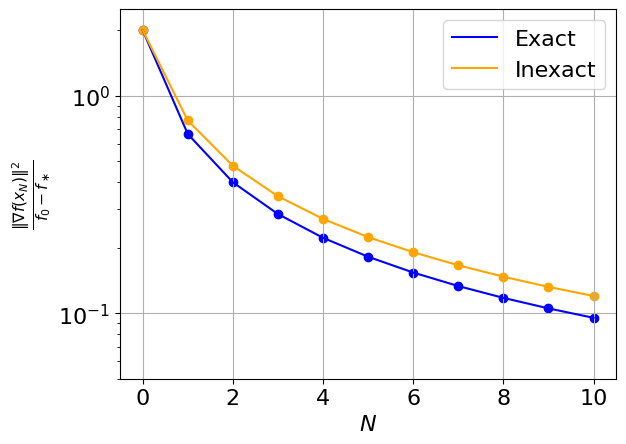

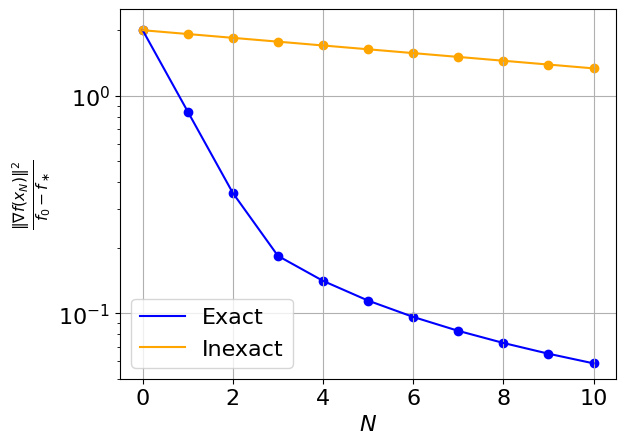

In [6]:
plot_scatter(N, exact_1, color='blue', label = "Exact")
plot_scatter(N, inexact_1, color='orange', label = "Inexact")
plt.legend(fontsize=16)
plt.grid()
plt.xlabel(r'$N$', fontsize=16)
plt.ylabel(r"$\frac{\|\nabla f(x_{N})\|^2}{f_0-f_\ast}$", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.yscale('log')
plt.ylim(0.05, 2.5)
plt.show()

plot_scatter(N, exact, color='blue', label = "Exact")
plot_scatter(N, inexact, color='orange', label = "Inexact")
plt.legend(fontsize=16)
plt.grid()
plt.xlabel(r'$N$', fontsize=16)
plt.ylabel(r"$\frac{\|\nabla f(x_{N})\|^2}{f_0-f_\ast}$", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.yscale('log')
plt.ylim(0.05, 2.5)
plt.show()

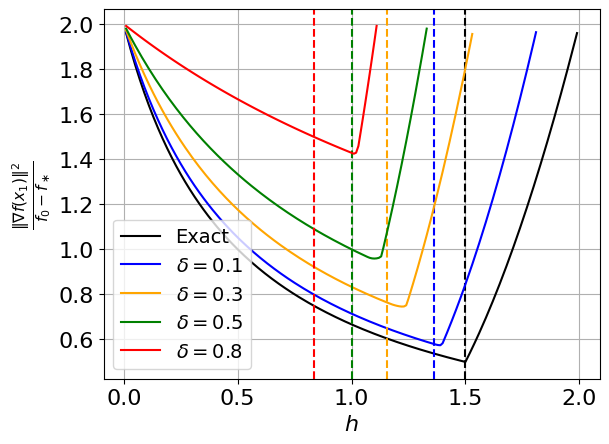

In [7]:
col = ['black', 'blue', 'orange', 'green', 'red']

for i in range(len(delta_list_visual)):
    if delta_list_visual[i] !=0:
        plt.plot(h_lists[i], 1/(rate_lists[i]+0.5), color = col[i], label = "$\\delta={}$".format(np.round(delta_list_visual[i], 1)))
        plt.axvline(3/(2*(1+delta_list_visual[i])), color = col[i], linestyle = '--')
    else:
        plt.plot(h_lists[i], 1/(rate_lists[i]+0.5), color = col[i], label = "Exact")
        plt.axvline(3/(2*(1+delta_list_visual[i])), color = col[i], linestyle = '--')

plt.legend(fontsize=14)
plt.xticks([0.,0.5,1.,1.5,2.],fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("$h$", fontsize=16)
plt.grid()
plt.ylabel(r"$\frac{\|\nabla f(x_{1})\|^2}{f_0-f_\ast}$", fontsize=16)
plt.show()

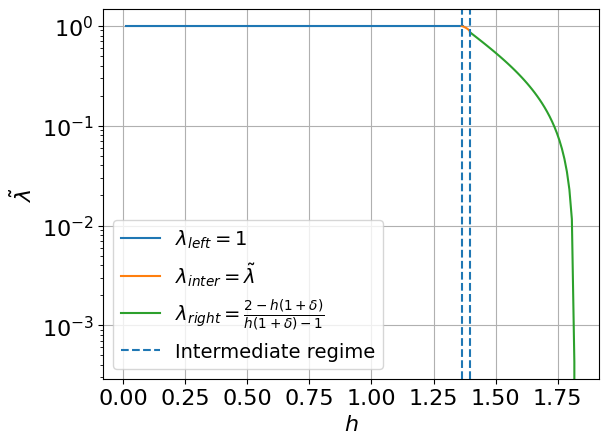

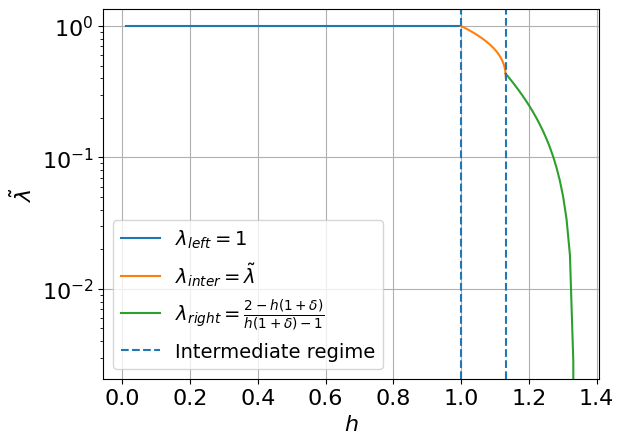

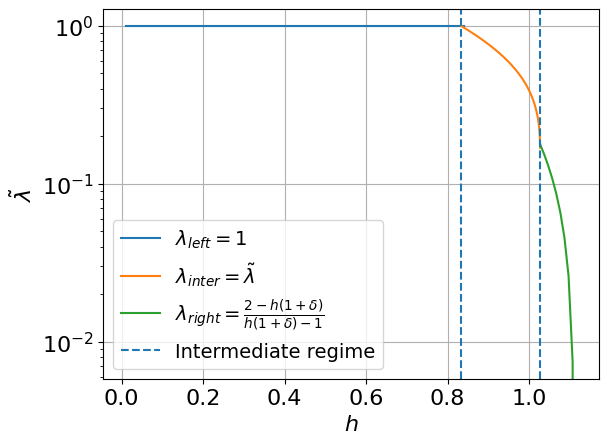

In [8]:
list_d = [0.1, 0.5, 0.8]
h_list_test = [h_list_test_1, h_list_test_5, h_list_test_8]
lambda_value = [lambda_value_1, lambda_value_5, lambda_value_8]

for i, fixed_d in enumerate(list_d):
    h_left = np.arange(0.01, 3/(2*(1+fixed_d)) + 0.01, 0.01)
    h_right = np.arange((3*fixed_d+2-np.sqrt(4-3*fixed_d**2))/(2*fixed_d*(fixed_d+1)), 2/(1+fixed_d) + 0.01, 0.01)

    plt.plot(h_left, np.ones(len(h_left)), label = r'$\lambda_{left} = 1$')
    plt.plot(h_list_test[i], lambda_value[i], label = r'$\lambda_{inter}=\tilde{\lambda}$')
    plt.plot(h_right, (2-h_right*(1+fixed_d))/(h_right*(1+fixed_d)-1), label = r'$\lambda_{right} = \frac{2-h(1+\delta)}{h(1+\delta)-1}$')
    # plt.plot(h_list_test, best_lambda_effective, label = r'Actual best $\lambda$')
    plt.xlabel(r'$h$', fontsize=16)
    plt.ylabel(r'$\tilde{\lambda}$', fontsize=16)
    plt.axvline(3/(2*(1+fixed_d)), linestyle = '--', label = "Intermediate regime")
    plt.axvline((3*fixed_d+2-np.sqrt(4-3*fixed_d**2))/(2*fixed_d*(fixed_d+1)), linestyle = '--')
    plt.yscale('log')
    plt.grid()
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(fontsize=14)
    plt.show()

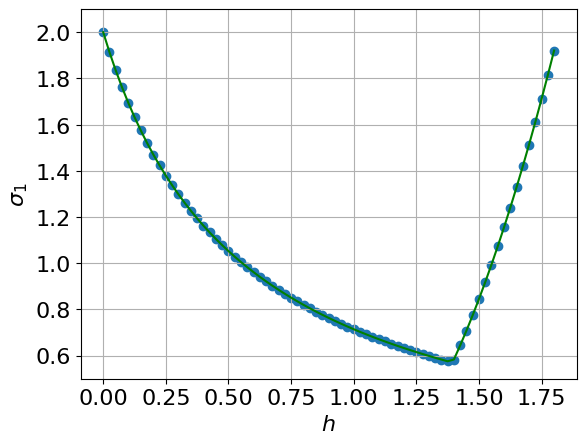

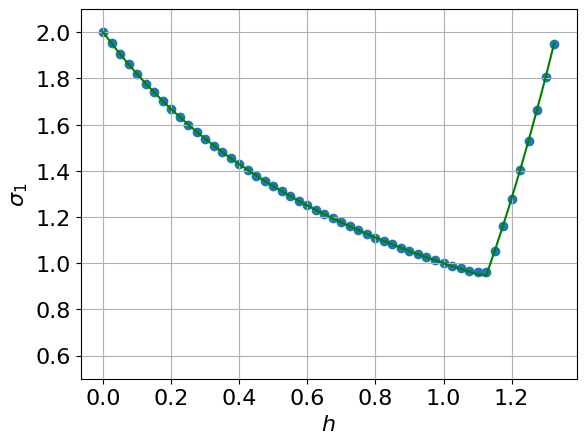

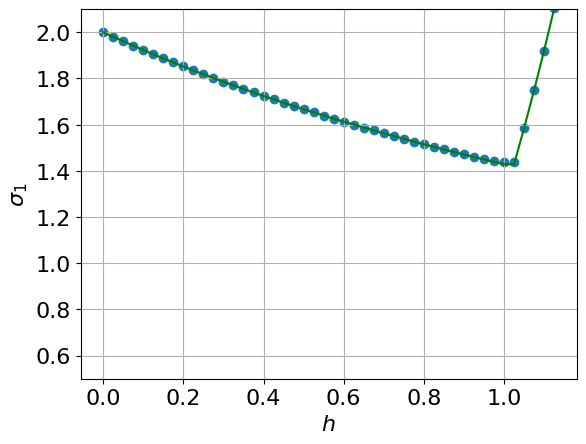

In [9]:
for delta in list_d:
    C = []
    hrange = np.arange(0, 2/(1+delta)+delta/50, 0.025)

    for h in hrange:
        try:
            C.append(PV(h, delta, n_steps=1))
        except:
            C.append([0,0,0,0])

    plt.scatter(hrange, 1/(np.array(C)[:,0]+0.5), label = "Convergence rate")
    plt.xlabel("$h$", fontsize=16)
    plt.ylabel(r"$\sigma_1$", fontsize=16)
    plt.plot(hrange, np.maximum(1/(hrange*(1-delta)+0.5), 2*(1-hrange*(1+delta))**2), color='green')
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.grid()
    plt.ylim(0.5,2.1)
    plt.show()

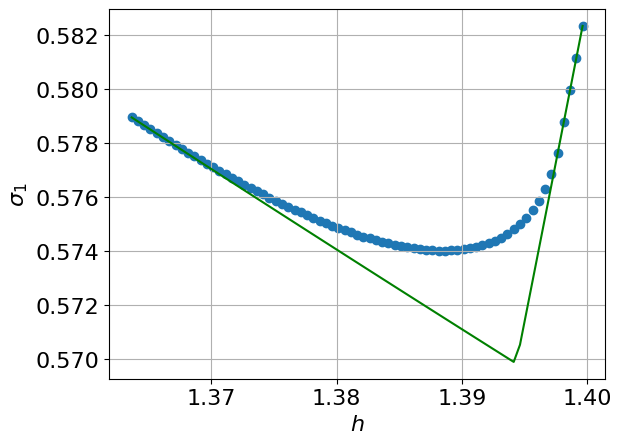

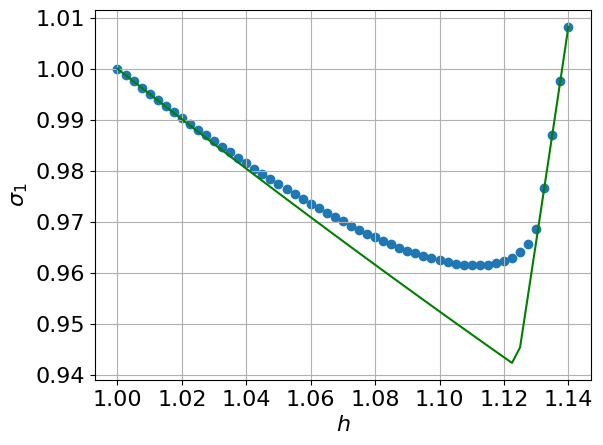

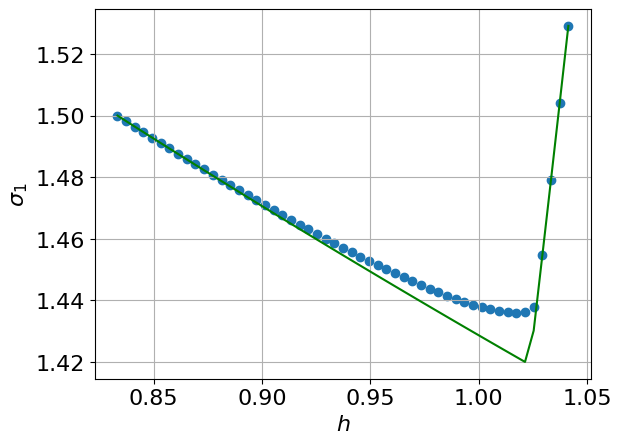

In [10]:
for delta in list_d:
    C = []
    hrange = np.arange(3/(2*(1+delta)), (3*delta+2-np.sqrt(4-3*delta**2))/((2*delta*(1+delta)))+delta/50, delta/200)

    for h in hrange:
        try:
            C.append(PV(h, delta, n_steps=1))
        except:
            C.append([0,0,0,0])

    plt.scatter(hrange, 1/(np.array(C)[:,0]+0.5), label = "Convergence rate")
    plt.xlabel("$h$", fontsize=16)
    plt.ylabel(r"$\sigma_1$", fontsize=16)
    plt.plot(hrange, np.maximum(1/(hrange*(1-delta)+0.5), 2*(1-hrange*(1+delta))**2), color='green')
    if delta == 0.1:
        plt.xticks([1.37,1.38,1.39,1.40], fontsize=16)
    elif delta == 0.5:
        plt.xticks([1., 1.02, 1.04, 1.06, 1.08, 1.10, 1.12, 1.14], fontsize=16)
    elif delta == 0.8:
        plt.xticks([0.85, 0.9, 0.95, 1., 1.05], fontsize=16)
    plt.yticks(fontsize=16)
    plt.grid()
    plt.show()

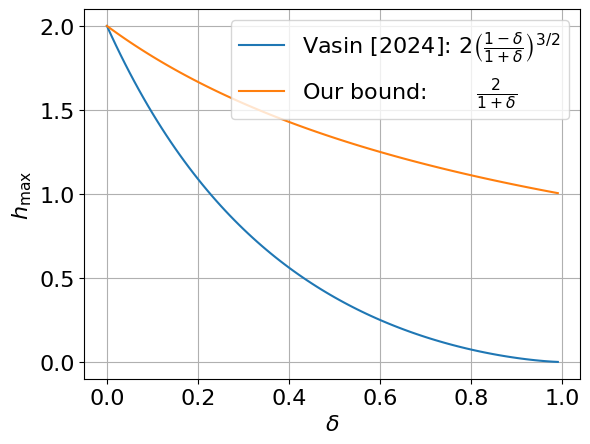

In [11]:
delta_range = np.arange(0., 1, 0.01)
vasin_max_h = 2*((1-delta_range) / (1+delta_range))**1.5
my_max_h = 2/(1+delta_range)

plt.plot(delta_range, vasin_max_h, label=r'Vasin [2024]: $2\left(\frac{1-\delta}{1+\delta}\right)^{3/2}$')
plt.plot(delta_range, my_max_h, label=r'Our bound:       $\frac{2}{1+\delta}$')
plt.xlabel(r'$\delta$', fontsize=16)
plt.ylabel(r'$h_{\text{max}}$', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks([0,0.5,1.,1.5,2.0],fontsize=16)
plt.legend(fontsize=16)
plt.grid()

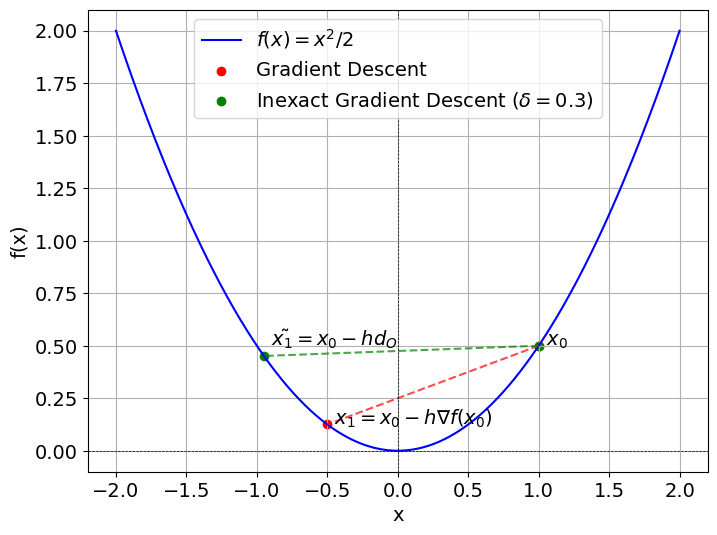

In [12]:
# Define the function and its derivative
def f(x):
    return x**2 /2

def f_prime(x):
    return x

# Gradient descent parameters
x0 = 1 # Starting point
step_size = 1.5
iterations = 1  # Number of iterations
delta = 0.3

# Perform gradient descent
x_values = [x0]
x_values_inexact = [x0]
for _ in range(iterations):
    x_new = x_values[-1] - step_size * f_prime(x_values[-1])
    x_values.append(x_new)
    x_new_inexact = x_values_inexact[-1] - step_size * (1+delta)*f_prime(x_values_inexact[-1])
    x_values_inexact.append(x_new_inexact)

# Generate x values for plotting the function
x = np.linspace(-2, 2, 500)
y = f(x)

# Plot the function and gradient descent steps
plt.figure(figsize=(8, 6))
plt.plot(x, y, label='$f(x) = x^2 / 2$', color='blue')
plt.scatter(x_values, [f(xi) for xi in x_values], color='red', label='Gradient Descent')
plt.text(x_values[0]+0.05, f(x_values[0]), '$x_0$', fontsize=14, color='black')
plt.text(x_values[1]+0.05, f(x_values[1]), '$x_1=x_0-h\\nabla f(x_0)$', fontsize=14, color='black')
plt.text(x_values_inexact[1]+0.05, f(x_values_inexact[1])+0.05, '$\\tilde{x_1}=x_0-hd_O$', fontsize=14, color='black')
plt.plot(x_values, [f(xi) for xi in x_values], color='red', linestyle='--', alpha=0.7)
plt.scatter(x_values_inexact, [f(xi) for xi in x_values_inexact], color='green', label='Inexact Gradient Descent ($\\delta=0.3$)')
plt.plot(x_values_inexact, [f(xi) for xi in x_values_inexact], color='green', linestyle='--', alpha=0.7)
plt.xlabel('x', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('f(x)', fontsize=14)
plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
plt.axvline(0, color='black', linewidth=0.5, linestyle='--')
plt.legend(fontsize=14)
plt.grid()
plt.show()

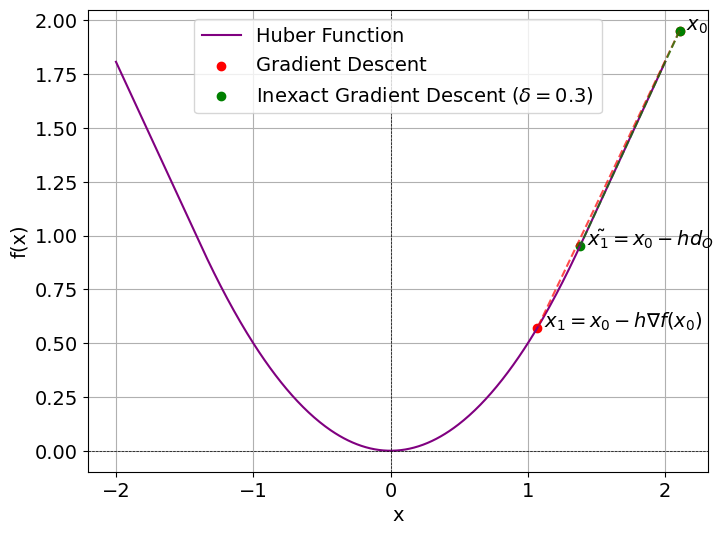

In [13]:
# Define the piecewise function
def piecewise_function(x, h, delta):
    threshold = 1 / np.sqrt(h * (1 - delta))
    result = np.where(
        np.abs(x) >= threshold,
        (1 / np.sqrt(h * (1 - delta))) * np.abs(x) - (1 / (2 * h * (1 - delta))),
        0.5 * x**2
    )
    return result

def piecewise_function_derivative(x, h, delta):
    threshold = 1 / np.sqrt(h * (1 - delta))
    derivative = np.where(
        np.abs(x) >= threshold,
        (1 / np.sqrt(h * (1 - delta))) * np.sign(x),
        x
    )
    return derivative

# Compute the function values
h = 0.75  # Use the step size as h
y_piecewise = piecewise_function(x, h, delta)

# Gradient descent parameters
x0 = np.sqrt(h*(1-delta)) + 1/np.sqrt(h*(1-delta))  # Starting point
step_size = h
iterations = 1  # Number of iterations
delta = 0.3

# Perform gradient descent
x_values = [x0]
x_values_inexact = [x0]
for _ in range(iterations):
    x_new = x_values[-1] - step_size * piecewise_function_derivative(x_values[-1], h, delta)
    x_values.append(x_new)
    x_new_inexact = x_values_inexact[-1] - step_size * (1-delta)*piecewise_function_derivative(x_values_inexact[-1], h, delta)
    x_values_inexact.append(x_new_inexact)

# Plot the piecewise function
plt.figure(figsize=(8, 6))
plt.plot(x, y_piecewise, label=r'Huber Function', color='purple')
plt.scatter(x_values, [piecewise_function(xi, h, delta) for xi in x_values], color='red', label='Gradient Descent')
plt.text(x_values[0]+0.05, piecewise_function(x_values[0], h, delta), '$x_0$', fontsize=14, color='black')
plt.text(x_values[1]+0.05, piecewise_function(x_values[1], h, delta), '$x_1=x_0-h\\nabla f(x_0)$', fontsize=14, color='black')
plt.text(x_values_inexact[1]+0.05, piecewise_function(x_values_inexact[1], h, delta), '$\\tilde{x_1}=x_0-hd_O$', fontsize=14, color='black')
plt.plot(x_values, [piecewise_function(xi, h, delta) for xi in x_values], color='red', linestyle='--', alpha=0.7)
plt.scatter(x_values_inexact, [piecewise_function(xi, h, delta) for xi in x_values_inexact], color='green', label='Inexact Gradient Descent ($\\delta=0.3$)')
plt.plot(x_values_inexact, [piecewise_function(xi, h, delta) for xi in x_values_inexact], color='green', linestyle='--', alpha=0.7)
plt.xlabel('x', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('f(x)', fontsize=14)
plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
plt.axvline(0, color='black', linewidth=0.5, linestyle='--')
plt.legend(fontsize=14)
plt.grid()
plt.show()

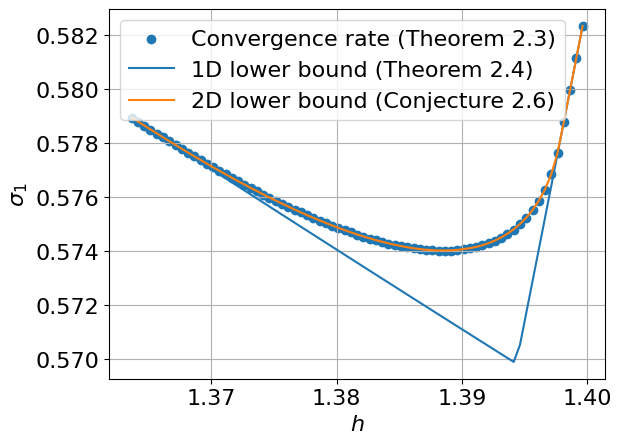

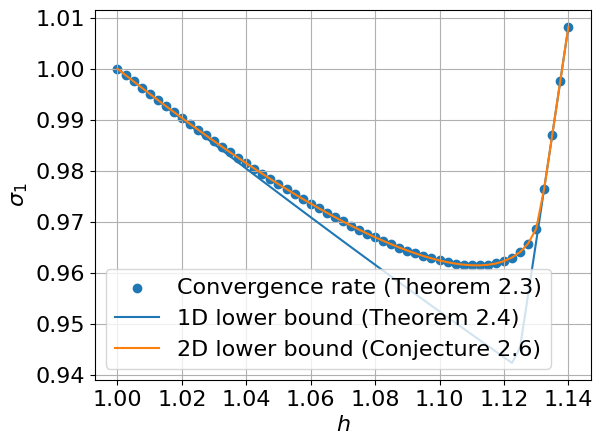

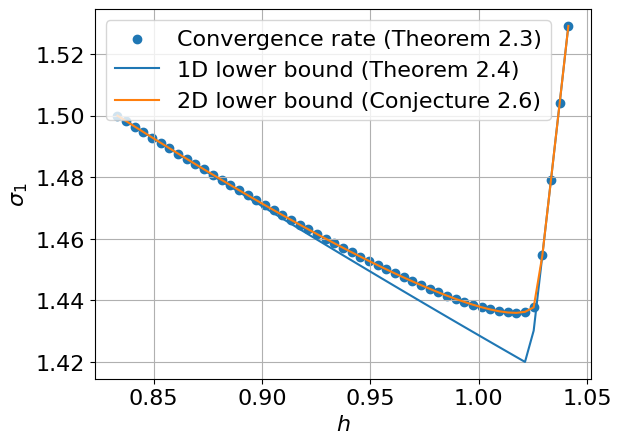

In [ ]:
for delta in list_d:

    C = []
    hrange = np.arange(3/(2*(1+delta)), (3*delta+2-np.sqrt(4-3*delta**2))/((2*delta*(1+delta)))+delta/50, delta/200)
    for h in hrange:
        try:
            C.append(PV(h, delta, n_steps=1))
        except:
            C.append([0,0,0,0])
    
    C_2D = []
    for h in hrange:
        try:
            C_2D.append(non_convex_pep_like(h, delta, two_2 = True)[0])
        except:
            C_2D.append(0)

    plt.scatter(hrange, 1/(np.array(C)[:,0]+0.5), label="Convergence rate (Theorem 2.3)")
    plt.plot(hrange, np.maximum(1/(hrange*(1-delta)+0.5), 2*(1-hrange*(1+delta))**2), label="1D lower bound (Theorem 2.4)")
    plt.plot(hrange, 1/(1/np.array(C_2D)+0.5), label="2D lower bound (Conjecture 2.6)")
    plt.xlabel("$h$", fontsize=16)
    plt.ylabel(r"$\sigma_1$", fontsize=16)
    plt.legend(fontsize=16)
    if delta == 0.1:
        plt.xticks([1.37,1.38,1.39,1.40], fontsize=16)
    elif delta == 0.5:
        plt.xticks([1., 1.02, 1.04, 1.06, 1.08, 1.10, 1.12, 1.14], fontsize=16)
    elif delta == 0.8:
        plt.xticks([0.85, 0.9, 0.95, 1., 1.05], fontsize=16)
    plt.yticks(fontsize=16)
    plt.grid()
    plt.show()

In [15]:
h_list = np.linspace(0.99, 1.133, 200)
test_exact = np.zeros_like(h_list)
g0_list = []
d0_list = []
g1_list = []
lower_bound = []
delta = 0.5

for i in range(len(h_list)):
    a,b,c,d = non_convex_pep_like(h_list[i], delta, truncated_mantissa=False)
    test_exact[i] = a
    g0_list.append(b)
    d0_list.append(c)
    g1_list.append(d)
    lower_bound.append(non_convex_pep_like(h_list[i], delta, truncated_mantissa=False, intermediate=False)[0])
    print(str((i+1)/len(h_list)*100) + "%", end="\r")

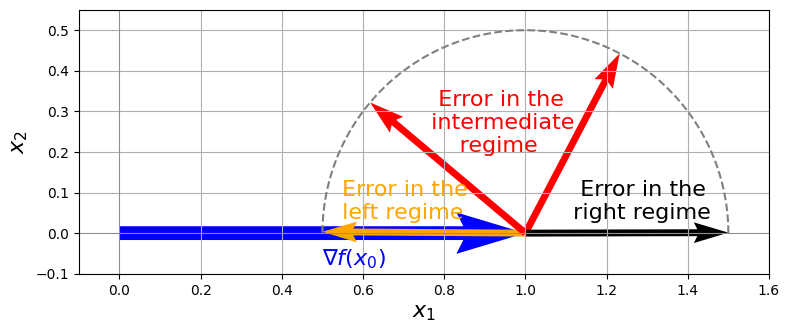

In [16]:

indices = [0, 130, 195, 199]
g0 = np.array([g0_list[i] for i in indices])
d0 = np.array([d0_list[i] for i in indices])

# Normalize the gradients for plotting
g0_norm = g0 / np.linalg.norm(g0, axis=1, keepdims=True)
errors = (d0 - g0) / np.linalg.norm(g0, axis=1, keepdims=True)

# Prepare plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_aspect('equal')
ax.axhline(0, color='gray', linewidth=0.5)
ax.axvline(0, color='gray', linewidth=0.5)


# Plot true gradient (blue horizontal arrow)
ax.quiver(0, 0, g0_norm[0, 0], g0_norm[0, 1], angles='xy', scale_units='xy', scale=1, 
            color='blue', width=0.02)

colors = ['orange', 'red', 'red', 'black']
for i in range(len(g0)):
    # Plot error vector (from tip of true gradient)
    base = g0_norm[i]
    ax.quiver(base[0], base[1], errors[i, 0], errors[i, 1], angles='xy', scale_units='xy', scale=1, 
              color=colors[i], width=0.01)
    
    # Label the inexact gradient vector visually
    ax.plot(base[0] + errors[i, 0], base[1] + errors[i, 1], color=colors[i])

# Label once (common label)
ax.text(0.5, -0.08, r"$\nabla f(x_0)$", color='blue', fontsize=16)
ax.text(0.53, 0.035, " Error in the \n left regime", color='orange', fontsize=16)
ax.text(1.1, 0.035, "  Error in the \n right regime", color='black', fontsize=16)
ax.text(0.75, 0.2, "  Error in the \n intermediate \n     regime", color='red', fontsize=16)

theta = np.linspace(0, np.pi, 200)
x = 1 + 0.5 * np.cos(theta)
y = 0.5 * np.sin(theta)
ax.plot(x, y, '--', color = 'gray')

# Formatting
ax.set_xlim(-0.1, 1.6)
ax.set_ylim(-0.1, 0.55)
# ax.set_title("Inexact Gradient Errors at Different Step Sizes", fontsize=14)
ax.set_xlabel("$x_1$", fontsize = 16)
ax.set_ylabel("$x_2$", fontsize = 16)
ax.grid(True)
plt.tight_layout()
plt.show()

/tmp/ipykernel_277378/3737564004.py:22: RuntimeWarning: divide by zero encountered in scalar divide
  rate_full[i] = 1/(full_h_all_rates[i] * (1-delta_full))


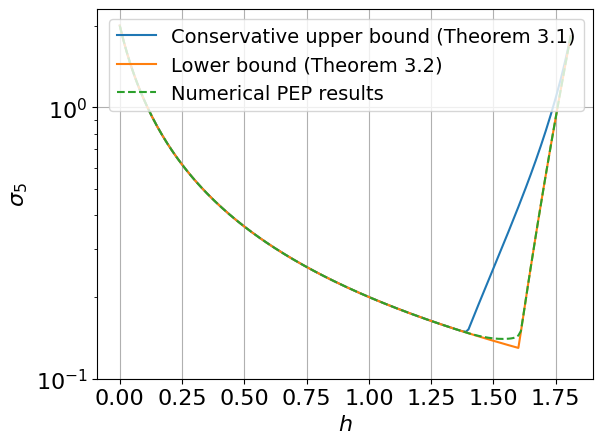

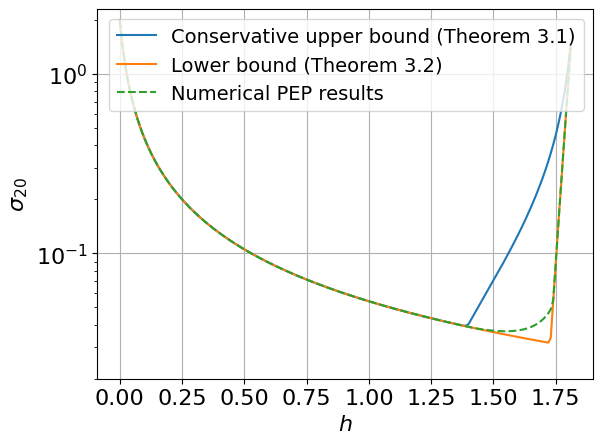

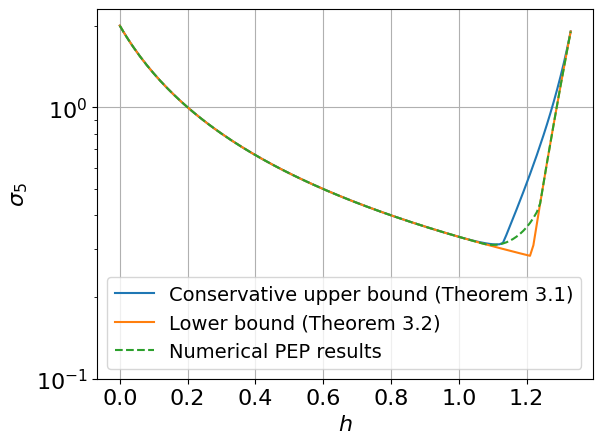

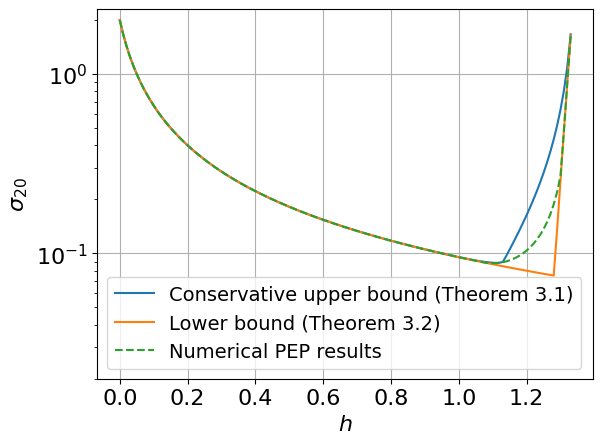

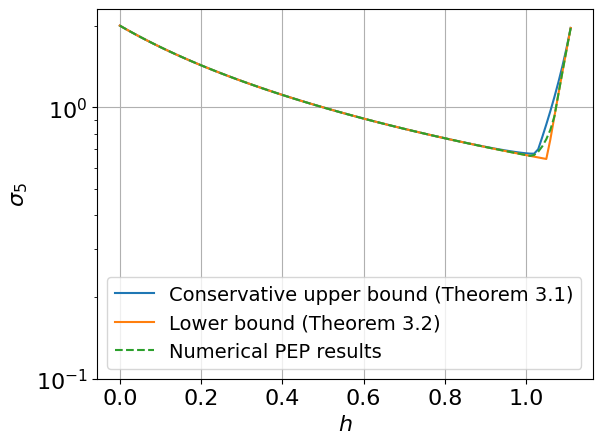

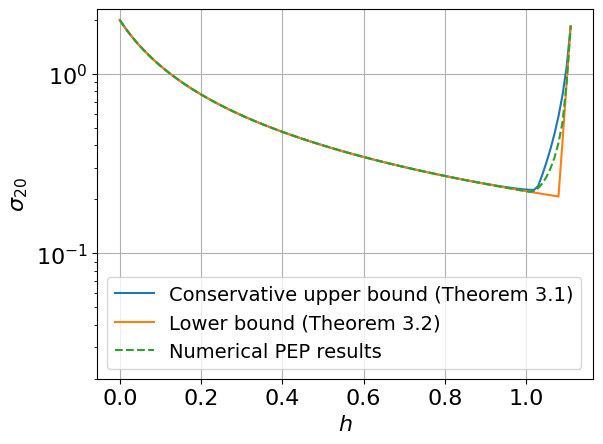

In [18]:
l = sym.Symbol('lambda')

for delta_full in list_d:
    for n_steps_full in [5,20]:

        def eq_on_lambda(l,d,h):
            return ((d**2-1)*h**2+2*h)*l**3 + (2*(d**2-1)*h**2+5*h-4)*l**2 + ((d**2-1)*h**2+4*h-4)*l+h-1

        def rate_in_right_sense(l,h):
            return (2*l)/(h*l**2+2*(h-1)*l+h-1)

        # full_h_all_rates = np.arange(0, 2/(1+delta_full), 0.005)
        full_h_all_rates = np.arange(0, 2/(1+delta_full), 0.01)

        rate_full = np.zeros(len(full_h_all_rates))
        rate_full_PEP = np.zeros(len(full_h_all_rates))

        for i in range(len(full_h_all_rates)):
            rate_full_PEP[i] = np.sum(my_PEP(full_h_all_rates[i], delta_full, n_steps=n_steps_full, metric="min")[3])

            if full_h_all_rates[i] <= 3/(2*(1+delta_full)):
                rate_full[i] = 1/(full_h_all_rates[i] * (1-delta_full))
            elif full_h_all_rates[i] >= (3*delta_full+2-np.sqrt(4-3*delta_full**2))/(2*delta_full*(1+delta_full)):
                rate_full[i] = 2/((1-full_h_all_rates[i]*(1+delta_full))**(-2) - 1)
            else:
                l_current = sym.re(sym.solve(eq_on_lambda(l,delta_full, full_h_all_rates[i]),l)[2])
                rate_full[i] = rate_in_right_sense(l_current, full_h_all_rates[i])    

        plt.plot(full_h_all_rates, 1/(n_steps_full/rate_full+0.5), label = "Conservative upper bound (Theorem 3.1)")
        plt.plot(full_h_all_rates, np.maximum(1/(n_steps_full*full_h_all_rates*(1-delta_full)+0.5), 2*(1-full_h_all_rates*(1+delta_full))**(2*n_steps_full)), label = "Lower bound (Theorem 3.2)")
        plt.plot(full_h_all_rates, 1/(rate_full_PEP+0.5), label = "Numerical PEP results", linestyle = '--')
        plt.legend(fontsize = 14)
        plt.xlabel(r'$h$', fontsize=16)
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        plt.grid()
        if n_steps_full == 20:
            plt.ylim(0.02,2.3)
            plt.ylabel(r"$\sigma_{20}$", fontsize=16)
        else:
            plt.ylim(0.1,2.3)
            plt.ylabel(r"$\sigma_{5}$", fontsize=16)

        plt.yscale('log')
        plt.show()

In [4]:
delta_list = np.arange(0.05, 1., 0.05)
nbr_steps_list = np.array([1,5,10,20,30])

best_h_1 = np.array([1.43857143, 1.38863636, 1.33934783, 1.3       , 1.26      ,1.22384615, 1.19111111, 1.16142857, 1.12448276, 1.1       ,1.07774194, 1.0575    , 1.04409091, 1.03235294, 1.02214286,1.01333333, 1.00581081, 0.99947368, 0.99923077])
best_h_5 = np.array([1.64357143, 1.53863636, 1.43434783, 1.355     , 1.29      ,1.23884615, 1.19611111, 1.16142857, 1.12448276, 1.1       ,1.07774194, 1.0575    , 1.04409091, 1.03235294, 1.02214286,1.01333333, 1.00581081, 0.99947368, 0.99923077])
best_h_10 = np.array([1.68857143, 1.54363636, 1.43934783, 1.36      , 1.295     ,1.23884615, 1.19611111, 1.16142857, 1.12448276, 1.1       ,1.07774194, 1.0575    , 1.04409091, 1.03235294, 1.02214286,1.01333333, 1.00581081, 0.99947368, 0.99923077])
best_h_20 = np.array([1.69357143, 1.54863636, 1.44434783, 1.36      , 1.295     ,1.24384615, 1.19611111, 1.16142857, 1.12448276, 1.1       ,1.07774194, 1.0575    , 1.04409091, 1.03235294, 1.02214286,1.01333333, 1.00581081, 0.99947368, 0.99923077])
best_h_30 = np.array([1.69380952, 1.54954545, 1.44630435, 1.36333333, 1.295     ,1.24076923, 1.19518519, 1.15785714, 1.12844828, 1.10166667,1.07725806, 1.06      , 1.04469697, 1.03117647, 1.01928571,1.01388889, 1.00486486, 1.00210526, 1.00051282])

best_h_several = np.array([best_h_1,best_h_5,best_h_10,best_h_20, best_h_30])

rate_end_middle = np.zeros((len(nbr_steps_list), len(delta_list)))
rate_best_numerical = np.zeros((len(nbr_steps_list), len(delta_list)))
for k in range(len(nbr_steps_list)):
    for i in range(len(delta_list)):
        rate_end_middle[k,i] = np.sum(my_PEP((3*delta_list[i]+2-np.sqrt(4-3*delta_list[i]**2))/(2*delta_list[i]*(1+delta_list[i])), delta=delta_list[i], metric='min', n_steps=nbr_steps_list[k])[3])
        rate_best_numerical[k,i] = np.sum(my_PEP(best_h_several[k,i], delta=delta_list[i], metric='min', n_steps=nbr_steps_list[k])[3])
        print(str(100*(i+1)/len(delta_list)) + "%", end = "\r")

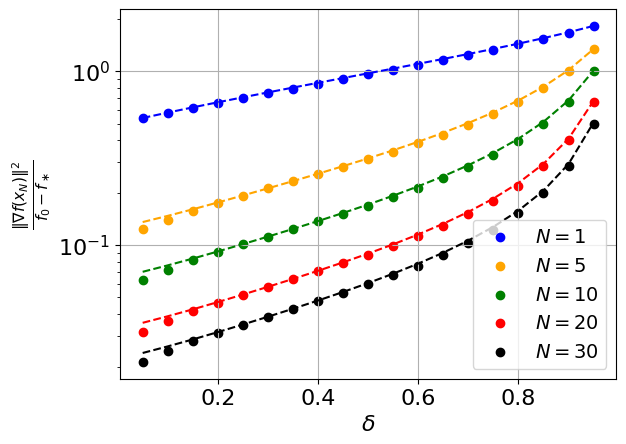

In [5]:
col = ['blue', 'orange', 'green', 'red', 'black']

for k in range(len(nbr_steps_list)):
    plt.scatter(delta_list, 1/(rate_best_numerical[k]+0.5), label = '$N={}$'.format(nbr_steps_list[k]), c=col[k])
    plt.plot(delta_list, 1/(rate_end_middle[k]+0.5), color=col[k], linestyle = "--")
plt.xlabel("$\\delta$", fontsize=16)
plt.ylabel(r"$\frac{\|\nabla f(x_{N})\|^2}{f_0-f_\ast}$", fontsize=16)
plt.legend(fontsize=14)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.yscale('log')
plt.grid()
plt.show()